<a href="https://colab.research.google.com/github/mahynski/chemometric-carpentry/blob/main/notebooks/1.4_Statistics_Background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
❓ ***Objective***: This notebook will provide some background in specific statistical ideas and tools.  For more details and information, please refer to the [NIST/SEMATECH e-Handbook of Statistical Methods](https://www.itl.nist.gov/div898/handbook/index.htm).

🔁 ***Remember***: You can always revisit this notebook for reference again in the future.  Ideas and best practices will be reinforced in future notebooks, so don't worry about remembering everything the first time you see something new.

🧑 Author: Nathan A. Mahynski

📆 Date: May 1, 2024

---

# $\chi^2$ Statistics

Recall that we stated many chemometric class models used for authentication follow a general pattern:

1. ⬇ Perform dimensionality reduction on a training set of data,
2. 💭 Draw a "bubble" around the data in the lower dimensional space assuming it is normally distributed (usually using a Mahalanobis distance),
3. 📏 Use $\chi^2$ statistics to determine how "far" a sample can be from the center of the distribution and still be considered a class member.

What is the $\chi^2$ [distribution](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3666.htm) and how are we going to use it?  The definition from [Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution) is: If $Z_1$, ..., $Z_k$ are [independent](https://en.wikipedia.org/wiki/Independence_(probability_theory)), [standard normal](https://en.wikipedia.org/wiki/Standard_normal) random variables, then the sum of their squares:

$$
Q = \sum_{i=1}^k Z_i^2
$$

is distributed according to the $\chi^2$ distribution with k degrees of freedom. This is usually denoted as $Q \sim \chi^2(k)$ or $Q \sim \chi_k^2$.  More generally, it can be shown that if $Z_i \sim N(\mu_i, \sigma_i^2)$, then their "autoscaled" values follow a $\chi^2$ distribution:

$$
Q = \sum_{i=1}^k \left( \frac{Z_i - \mu_i}{\sigma_i} \right)^2 \sim \chi^2(k)
$$

👉 Note that sometimes [Hotelling's](https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution) $T^2$ is used instead of $\chi^2$. This is often done when there is a very small amount of data available to account for uncertainty in estimating the (co)variance in the data; in the [limit of a large number of samples](https://online.stat.psu.edu/stat505/lesson/7/7.1/7.1.3) $T^2$ becomes $\chi^2$ distributed.  However, in practice the difference does not usually make a big difference for chemometric applications so this simplifying assumption is commonplace.

## Example

In [ ]:
# Select a certain number of degrees of freedom (dimensionality).
k = 5

In [ ]:
import numpy as np

# Fix the RNG seed so the same random numbers are generated each time.
np.random.seed(42)

# This is what 1 sample would look like, i.e., one "row" in the "X" matrix.
np.random.normal(size=k)

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337])

In [ ]:
# How many samples to draw?
N = 10000

Q = []
Z = np.zeros((N, k))
for i in range(N):
    # Generate k random numbers distributed according to Normal or  Gaussian
    # distribution.
    z = np.random.normal(size=k)
    Z[i,:] = z

    # Store the sum of squares.
    Q.append(np.sum(z**2))

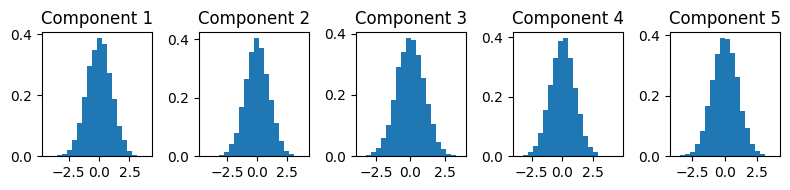

In [ ]:
# Let's plot each component of Z so we can see that they are all random and
# normally distributed.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=5, nrows = int(np.ceil(k / 5)), figsize=(8,2))
for i, ax in enumerate(axes.ravel()):
    _ = ax.hist(Z[:,i], bins=20, density=True)
    _ = ax.set_title(f'Component {i+1}')
plt.tight_layout()

In [ ]:
from scipy.stats import chi2

def plot_chi2(k, Q):
    fig, ax = plt.subplots(1, 1)

    # Plot the theoretical PDF
    x = np.linspace(chi2.ppf(0.0001, k), chi2.ppf(0.9999, k), 100)
    ax.plot(x, chi2.pdf(x, k), 'r-', lw=5, alpha=0.6, label=r'$\chi^2$({}) PDF'.format(k))

    # Plot the Q values we randomly created
    _ = ax.hist(np.array(Q), bins=50, density=True, label='Randomly Generated')

    plt.xlabel('Q')
    plt.ylabel('P(Q)')
    _ = plt.legend(loc='best')

    return ax

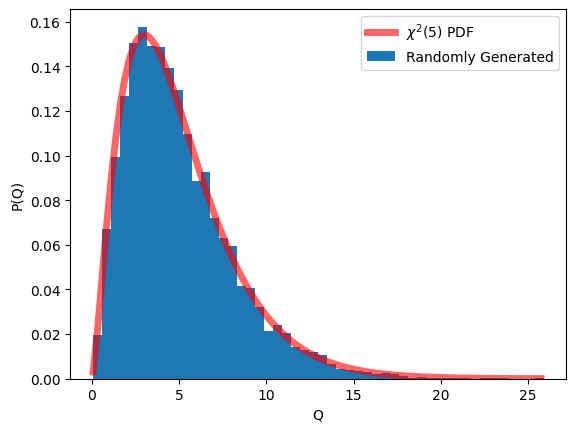

In [ ]:
_ = plot_chi2(k, Q)

## Applications

Why does this matter?  Observe that in the general formula above, we are reducing the dimensionality of the data first.  This is usually done through PCA or a similar approach.  The result is data that "lives" in a lower $k$ dimensional space than the one we started with.  The scaled Euclidean distance squared, $D^2$, a given observation is from the center of this data is then given by

$$
D^2 = \sum_{i=1}^k \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2
$$

where $\bar{x}_i$ and $s_i$ are the estimated mean and sample standard deviation, respectively.  The [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) is $k$ dimensions generalizes this "standard score" distance, using a covariance matrix, which can be used to compute $D^2$. Clearly, $D^2 \sim \chi^2(k)$.  

> 🤔 Recall, the [Pythagorean Theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem#Generalizations).

Below is an example from [Wikipedia](https://en.wikipedia.org/wiki/Mahalanobis_distance) showing different different thresholds. More importantly, note that there are several different ways to compute the sample mean and covariance matrix since these can be very sensitive to outliers. The naive way is shown in purple ("non-robust"). Two "robust" methods, the MCD and MVE methods are shown for comparison.  This is related to the process of "cleaning" your data.  Often this involves detection and removal of outliers before modeling can begin so that non-robust methods can be used.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Mahalanobis-distance-location-and-scatter-methods.png/620px-Mahalanobis-distance-location-and-scatter-methods.png" wigth=50/>


⚠ We need to be careful about how we clean the data (remove outliers). 🗣 Here is some more vocabulary:
* Masking - this can occur when we assume there are less outliers than there actually are in the data. For example, if we are setting our limits based on the assumption that a single outlier is present when there are in fact more, these additional outliers may influence the cutoff value (increase it) to the point where it seems like there are NO outliers at all!
* Swamping - this can occur when we assume there are too many outliers in the data. For example, if we are testing for several outliers when there is, in fact, only a single outlier, then the critical distance will be reduced so that many truly inlier points are considered outliers


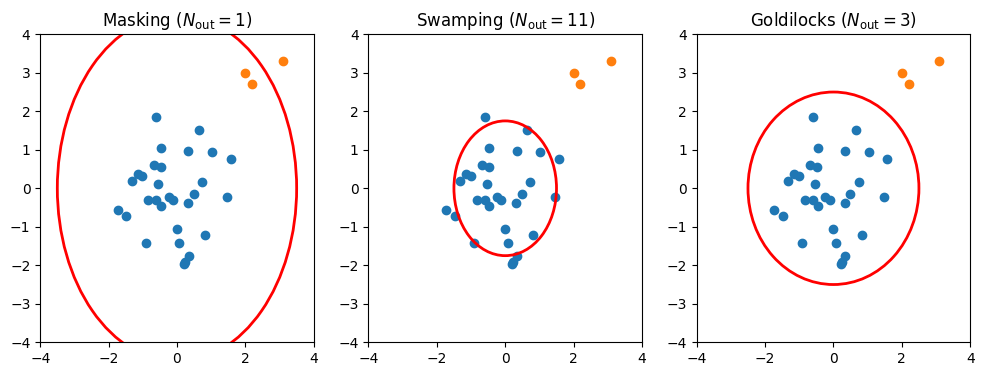

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
np.random.seed(42)

x = np.random.normal(size=60).reshape(30,2)
x_out = np.array([[2, 3], [2.2, 2.7], [3.1, 3.3]])

for ax in axes:
  ax.scatter(x[:,0], x[:,1])
  ax.scatter(x_out[:,0], x_out[:,1])
  ax.set_xlim(-4, 4)
  ax.set_ylim(-4, 4)

ellipse = Ellipse(xy=(0, 0), width=7, height=9, edgecolor='r', fc='None', lw=2)
axes[0].add_patch(ellipse)
ellipse = Ellipse(xy=(0, 0), width=3, height=3.5, edgecolor='r', fc='None', lw=2)
axes[1].add_patch(ellipse)
ellipse = Ellipse(xy=(0, 0), width=5, height=5, edgecolor='r', fc='None', lw=2)
axes[2].add_patch(ellipse)

axes[0].set_title('Masking '+r'$(N_{\rm out}=1)$')
axes[1].set_title('Swamping '+r'$(N_{\rm out}=11)$')
_ = axes[2].set_title('Goldilocks ' +r'$(N_{\rm out}=3)$')

Some advice straight from [ITL @NIST](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm):
> "Due to the possibility of masking and swamping, it is useful to complement formal outlier tests with graphical methods. Graphics can often help identify cases where masking or swamping may be an issue. Swamping and masking are also the reason that many tests require that the exact number of outliers being tested must be specified.
>
> Also, masking is one reason that trying to apply a single outlier test sequentially can fail. For example, if there are multiple outliers, masking may cause the outlier test for the first outlier to return a conclusion of no outliers (and so the testing for any additional outliers is not performed)."

This is one reason many chemometric methods are accompanied by some graphical tools (more so than most machine learning methods). Certain chemometric tools have data cleaning built in, which is sometimes convenient. Again, this is an art 🎨.

Even after cleaning, we still need to determine the size of the "bubble" in step 2 (illustrated above) - this is often done by selecting a [Type I error rate](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors), $1-\alpha$. In [Hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_test), we are trying to determine if there is sufficient evidence to reject the "null hypothesis", that is, the baseline assumption that is the status quo.  In this application, the status quo is that a sample is expected to be similar to the known samples of an "authentic" class, for example.  A Type I error is when the null hypothesis is rejected, but it is actually true.  In other words, we are rejecting an "authentic" sample as being "inauthentic" even though it was, in fact, actually authentic.  This is set by the user, but typically values of $\alpha = 0.05$ or $\alpha = 0.01$ are selected.

👉 The critical distance we use to determine class membership is then computed from the "percent point function" of the $\chi^2$ distribution.  Recall, this is the limit at which a certain percent of the distribution fall below it.

Though there will be variations, this is a common theme in chemometric models.

In [ ]:
alpha = 0.05

d2_crit = chi2.ppf(1 - alpha, df=k)
d2_crit

11.070497693516351

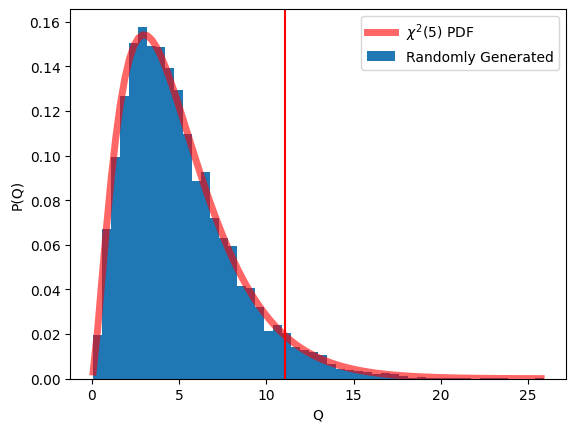

In [ ]:
ax = plot_chi2(k, Q)
ax.axvline(d2_crit, color='red')

In [ ]:
# Let's see how close we came to 1-alpha being below this cutoff in our sampled
# data.
np.sum(np.array(Q) < d2_crit) / len(Q)

0.9497

# Performance Metrics

## Regression Models

Regression models are often scrored based on their [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), $R^2$.  This can be confusing because $R^2 \neq R*R$.  That is because "$R^2$" is a term defined as:

$$
R^2 \equiv 1 - \frac{SS_{\rm res}}{SS_{\rm tot}}
$$

where $SS_{\rm res}$ is the residual sum of squares, and $SS_{\rm tot}$ is the total sum of squares.  If $\hat{y_i}$ is the predicted value for a point whose true value is $y_i$ then:

$$
SS_{\rm res} = \sum (y_i - \hat{y_i})^2
$$

The total sum of squares is based on the mean value, $\bar{y}$.

$$
SS_{\rm tot} = \sum (y_i - \bar{y})^2
$$

In essence, $R^2$ describes the average accuracy of the model (how close $y_i$ and and $\hat{y_i}$ are) in units of the natural variation of $y$ values around their mean.  This is because the "simplest, reasonable but uninformed" approach to predicting $y_i$ is just to guess the average each time.  We can think of this as a baseline algorithm, so we quantify other models relative to this.

In [ ]:
class BaselineRegressor:
    """
    A simple baseline regression model.
    """
    def fit(self, X, y):
        self.average = np.mean(y)
        return self

    def predict(self, X):
        # Ignore X and just predict the average y seen during training.
        return np.array([self.average]*X.shape[0])

def r2(model, x, y):
    """
    Compute the coefficient of determination.
    """
    ss_res = np.sum((y - model.predict(x))**2)
    ss_tot = np.sum((y - np.mean(y))**2)

    return 1.0 - ss_res/ss_tot

In [ ]:
import numpy as np
np.random.seed(42)

# Create some dummy linear data.
x = np.linspace(0, 10, 100).reshape(-1,1) # sklearn expects this as a column
y = 3.2*x.ravel() + 4.1 + np.random.normal(size=x.shape[0])

# Now let's fit a linear model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
_ = lr.fit(x, y)

# Check this learned the similar coefficients we used to generate the data.
print(lr.coef_, lr.intercept_)

[3.21379327] 3.927187145922627


In [ ]:
print(
    lr.score(x, y), # This function's score return the R^2 value.
    r2(lr, x, y) # Our manual calculation
)

0.9908049479870445 0.9908049479870445


In [ ]:
# The baseline model has R^2 = 0.
base = BaselineRegressor()
_ = base.fit(x, y)

r2(base, x, y)

0.0

In [ ]:
# What if we created an algorithm that generates random guesses instead?
class Guesser:
    """
    A model which just makes random guesses.
    """
    def __init__(self, seed=42):
        self.rng = np.random.default_rng(seed=seed)

    def fit(self, X, y):
        # Learn nothing!
        return self

    def predict(self, X):
        # Ignore X and just predict the average y seen during training.
        return self.rng.normal(size=X.shape[0])

In [ ]:
# R^2 is actually < 0!  This is because you can do worse than guessing the mean
# of the response.
guess = Guesser()
r2(guess, x, y)

-4.566646416969218

---
> ❗ For regression models, you should think of "guessing the average" as the standard reference algorithm all other algorithms will be compared against.  The bounds on the coefficient of determination are actually, $-\infty < R^2 \le 1$, not $0 \le R^2 \le 1$!
---

## Classification Models

There are numerous types of classification models we encounter in chemometrics, e.g., multiclass vs. multilabel.  Depending on the model, different metrics may be needed to explain the performance of the model. Even before we get to that we need to address the analog of the $R^2$ dilemma we just saw.  

❓ Q: For classification models, what is the "simplest, reasonable but uninformed" algorithm we could use to guess the answer?

🙋 A: This amounts to just guessing the most commonly observed class.

In fact, many classification models, in an attempt to learn something, accidentally pick up on this and end up biased.  This is why "class imbalance" is so important to monitor when training classification models.  

In [ ]:
import numpy as np

class BaselineClassifier:
    """
    A simple baseline classification model.
    """
    def fit(self, X, y):
        y = y.tolist()
        self.most_common = max(set(y), key = y.count)
        return self

    def predict(self, X):
        # Ignore X and just predict the most_common y seen during training.
        return np.array([self.most_common]*X.shape[0])

    def score(self, X, y):
      return np.sum(self.predict(X) == y) / len(y)

In [ ]:
# Let's examine a toy dataset.
import sklearn
from sklearn import datasets
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

In [ ]:
# 0 = Malignant, 1 = Benign
y.value_counts()

# Here we have almost twice as many benign examples as malignant ones

,count
target,
1,357
0,212


In [ ]:
# Predicting the majority class would have an accuracy of ...
357 / (212+357)

0.6274165202108963

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)

In [ ]:
# Compared to random guessing (accuracy ~ 0.5) this "appears" to be better.
base = BaselineClassifier()
base.fit(X_train.values, y_train.values)
base.score(X_test, y_test)

0.631578947368421

In [ ]:
# Many sklearn models have a class_weight option that helps balance the
# model performance.  We will cover this in more detail later.
from sklearn.ensemble import RandomForestClassifier

rf_balanced = RandomForestClassifier(
    n_estimators=10,
    class_weight='balanced',
    random_state=42
  )
_ = rf_balanced.fit(X_train, y_train)

In [ ]:
rf_balanced.score(X_test, y_test)

0.9473684210526315

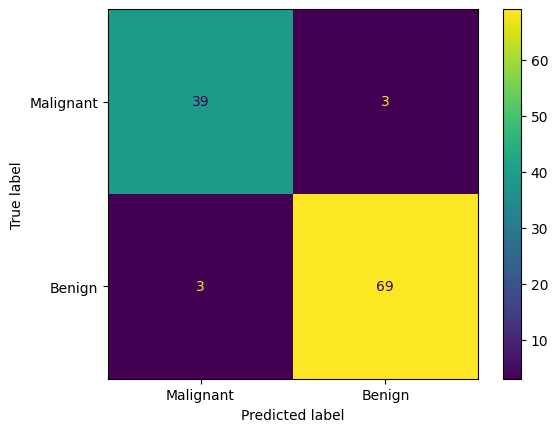

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(rf_balanced, X_test, y_test, display_labels=['Malignant', 'Benign'])

---
> ❗ [Evidently AI](https://www.evidentlyai.com) has a very nice visual guide to [classification metrics](https://www.evidentlyai.com/classification-metrics) for machine learning / statistical models you can check out for more details.
---

### The Confusion Matrix

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) describes the performance of a classifier.  The properties of this matrix will change depending on what sort of classifier is being used.  The differences will be reviewed for each category below, but for now let's look at the basics. Consider a case where we have 2 classes: P (positive) and N (negative).  A confusion matrix will be 2x2 and have entries labeled like this:

| | Predicted P | Predicted N |
|---|---|---|
| Actual P | TP | FN |
| Actual N | FP | TN |

The columns represent the number of times a point was predicted to be in each class (here, P or N).  The rows correspond to the actual value of these observations.  In this example we have only 2 classes (binary) which are assumed to be mutually exclusive; however, we may have models with more (multiclass), or classes that are not mutually exclusive (multilabel).

* TP = True Positives; these are points that are predicted to be class P and are, in fact, members of class P.
* FN = False Negatives; these are points that are predicted to be class N but are, in fact, members of class P.
* FP = False Positives; these are points that are predicted to be class P but are, in fact, members of class N.
* TN = True Negatives; these are points that are predicted to be class N and are, in fact, members of class N.

👉 We can [combine elements](https://www.evidentlyai.com/classification-metrics/confusion-matrix#classification-quality-metrics) of this confusion matrix to get different performance metrics.



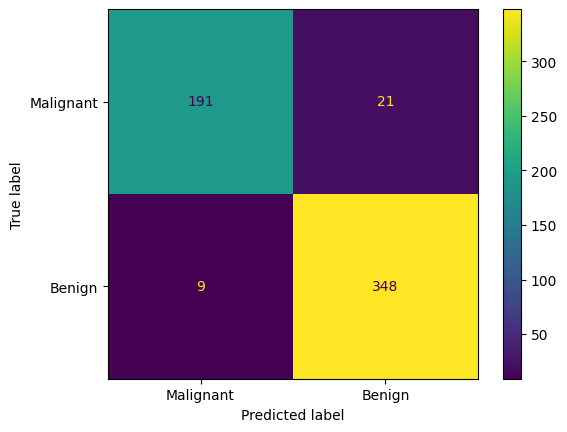

In [ ]:
# Let's examine a toy dataset with 3 classes.
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

# Let's train a simple nearest-neighbor classifier.
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

# It is very simple to plot this matrix with sklearn.
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(model, X, y, display_labels=['Malignant', 'Benign'])

### Binary Classifiers

For certain models, we will train using multiple (>2) classes.  These can be used under a variety of settings, but most authentication tasks are handled with one-class classifiers (OCC).  For OCCs, we effectively have a binary prediction (e.g., authentic or not) where the results are mutually exclusive.  For these cases the model assigns each point to a single class (column in the confusion matrix).  As a result, the row-wise sums yield to the total number of each class: $P = TP + FN$, $N = FP + TN$. This is no longer true when considering multilabel classifiers.

#### Common Summary Metrics

One of the most common metrics for assessing the performance of these (closed set) classifiers is with accuracy (ACC):

$$
ACC = \frac{{\rm correct~predictions}}{{\rm total~number~of~predictions}} = \frac{TP+TN}{TP+FN+FP+TN}
$$

Many binary tasks refer involve one class which is "positive" while the other class is the remainder, or "negative", akin to a OvA formulation.  This is subtly different from having 2 classes on equal footing.  Authentication problems are reminiscent of this situtation.  

> Consider the case where a model is performing hypothesis testing and members of the positive class are those for which you fail to reject $H_0$ whereas the negative class is composed those where $H_0$ was rejected. Recall that the [null hypothesis](https://en.wikipedia.org/wiki/Null_hypothesis), $H_0$, should be formulated such that it reflects the "status quo" or a lack of evidence to prove a difference exists.  In authentication, this takes the form of modeling an authentic substance where $H_0$ stipulates that a new sample is also authentic, unless there exists proof otherwise.  A "true positive" occurs when an authentic sample is correctly identified as authentic; a "false positive" occurs when an inauthentic sample was classified as authentic because there was not enough evidence to prove otherwise.

For imbalanced systems the true positive (TPR) and false positive rate (FPR) can be very helpful since ACC is biased toward the majority class.  These are related to the concepts of [sensitivity (SNS) and specificity (SPS)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) which are also commonly used.  We usually consider good classifiers to be both sensitive and specific.

$$
FPR = \frac{FP}{FP + TN}
$$

$$
TPR = \frac{TP}{FN + TP} = SNS = REC = 1 - FNR
$$

Sometimes the term "recall" (REC) is also used to refer to the TPR. The true negative rate (TNR) is equivalent to specificity and complementary to FPR.  This is very important for multilabel classifiers.

$$
TNR = \frac{TN}{FP + TN} = SPS = 1 - FPR
$$

For example, it might be important to optimize the TPR so all examples of a class are detected even if that means we also falsely include some non-members of that class.  In authentication, the opposite is often true - we want to make sure the FPR is low because a false positive means accepting a sample as authentic when it is a fake.  In this case, this comes at the possible cost of rejecting more truly authentic ones.  In commerce, the impact this has on consumers and producers needs to be balanced.

$$
PRE = \frac{TP}{TP + FP}
$$

Precision is a similar concept as SPS, but is less commonly used in chemometrics.  Since "good" models generally have a good balance of SNS and SPS (or REC and PRE), these values are often combined.  The [F1 score](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) is commonly used in machine learning, though "efficiency" is often used for chemometric models (addressed in the next section).

$$
F1 = 2 \frac{PRE \times REC}{PRE + REC}
$$

Unlike the SPS vs SNS tradeoff, PRE and REC are both independent of the TNR.  If true negative rates are hard to reliably estimate then these may be better metrics to use; however, for [sitations with unbalanced classes the F1 score can be misleading](https://en.wikipedia.org/wiki/F-score#Criticism).  This is one reason it is less popular in chemometric authentication scenarios, since we often have one well-sampled "positive" class and a poorly sampled "alternative" class that is not well-defined anyway.


👉 This is a lot of terminology, but in chemometrics it seems to be most common to refer to models in terms of their SNS and SPS (the "true" positive and negative rates).  Still, it is good to know how these connect to terms in other fields.
* A higher SNS can be achieved by *increasing* the size of the $\chi^2$ ellipse depicted above, while
* A higher SPS tends to be achieved by *decreasing* the size of the $\chi^2$ ellipse.

#### Chemometric Efficiency

In authentication scenarios we often have one well-sampled target class and a variety of alternatives.  The "negative" class here is usually impossible to completely sample so it is not wise to treat this as a true "class" of its own.  Therefore, the meaning / applicability of the metrics above require careful consideration.

Akin to the F1 score, a harmonic mean of SNS and SPS called [efficiency (EFF)](https://www.sciencedirect.com/science/article/abs/pii/S0003267000864685) is often used to evaluate class models.

$$
EFF = \sqrt{SNS \times SPS} = \sqrt{\frac{TP \times TN}{(TP+FN)(TN+FP)}}
$$

👉 Note that to evaluate EFF we need to have SPS; to have SPS we need to use examples of things that are NOT the class we are modeling.  When using a "rigorous" training approach, this is not allowed - in those cases, only SNS can be evaluated.  We will see this in action later.

Class models produce a binary prediction of "member" vs. "not a member" for the class being modeled.  Consider an example confusion matrix below.

|  | Predicted Member | Predicted Not |
| --- | --- | --- |
| Actual Member | 10 | 1 |
| Actually Not | 3 | 7 |

Then, overall we have:

In [ ]:
SNS = 10/(10+1)
SPS = 7/(3+7)
EFF = (SNS*SPS)**0.5

ACC = (10+7)/(10+1+3+7)

print(EFF, SNS, SPS, ACC)

0.7977240352174656 0.9090909090909091 0.7 0.8095238095238095


#### ROC and Related Curves

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png" width = 400, align = "right"/>  Another common metric is the "receiver operating characteristic" [(ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) in [binary classification](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).  This is a plot of the TPR (or SNS) on the y-axis vs. the FPR (or 1 - SPS) on the x-axis as hyperparameters, such as class membership threholds, are changed.  At the right is an example from Wikipedia.

A perfect model as TPR = 1 and FPR = 0 (top left corner).  By integrating the area under the ROC curve (AUROC) we can characterize the performance of a model relative to this perfect case where AUROC = 1.

The accuracy score can be interpreted as just a single point on the ROC curve.  It is also possible to compute the [area under the precision-recall (AUPRC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).  It is a common adage that the AUPRC is a better metric for binary classification tasks when class imbalance exists, but [this has been challenged recently](https://arxiv.org/abs/2401.06091).

These curves are less commonly using in chemometric settings, but a [modified variation on ROC curves has been proposed for evaluating class models](http://dx.doi.org/10.4155/bio.13.12).



### Multiclass Classifiers

There are [straightforward extensions](https://www.evidentlyai.com/classification-metrics/confusion-matrix#confusion-matrix-in-multi-class-classification) of the metrics we just reviewed for binary classifiers.  In this section, we are still referring to models which predict only single labels (mutually exclusive), but have more than 2 options to choose from.  Here, all classes are considered on "equal footing," though, so these are typically not used for authentication problems.  Again, due to this mutual exclusivity, the row-wise sums of the confusion matrix yield to the total number of each class.

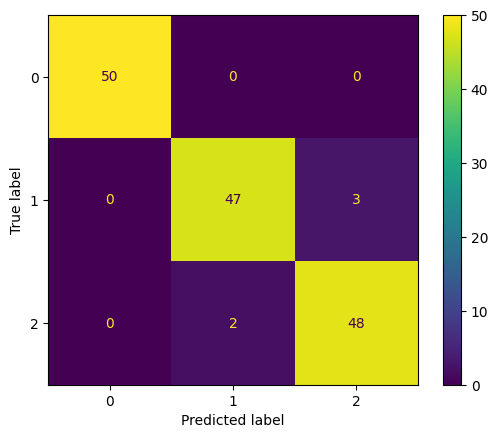

In [ ]:
# Let's examine a toy dataset with 3 classes.
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

# Let's train a simple nearest-neighbor classifier.
X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

# It is very simple to plot this matrix with sklearn.
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(model, X, y)

Going forward, we will refer to points in a confusion matrix as $n_{i,j}$ indicating that $n$ points from class $i$ have been predicted to belong to class $j$.

> 💡 When there are more than 2 classes performance metrics can be weighted "microscopically" or "macroscopically" based on the performance on individual classes using a OvA approach; e.g., see [sklearn's documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel).  See [Evidently AI's guide](https://www.evidentlyai.com/classification-metrics/multi-class-metrics#binary-vs-multi-class-classification) for more details; essentially, all the "total" metrics discussed below are [microscopically averaged](https://www.evidentlyai.com/classification-metrics/multi-class-metrics#macro-vs-micro-average) which is more common in chemometrics than macroscopic averaging.

It is clear how accuracy (ACC) is (microscopically) extended to multiclass systems, since it refers to the rate of correct preditions.

$$
ACC = \frac{1}{M} \sum_{i=1}^N n_{i,i} = (50+47+48)/150
$$

For multiclass classifiers, the mutual exclusivity of predictions (model predicts 1 and only 1 class) gives us the property that:

$$
M = \sum_{i=1}^N \sum_{j=1}^N n_{i,j} = 150
$$

Let's revist how EFF is calculated for multiclass classifiers.  In such cases, SNS and SPS can be computed for each class or for the overall dataset; in the former, these metrics are referred to, e.g., as class sensitivity (CSNS) while in the latter the prefix "total" (e.g., total sensitivity, TSNS) is used.  Thus,

$$
TSNS = ACC
$$

So TSNS is just the (normalized) sum of the diagonal of the confusion matrix. Specificity is determined by the false positive rate; in this case, a false "positive" occurs when any point is assigned incorrectly.  This is a different convention than with binary classifiers; previously, positive and negative were 2 different classes so FPR referred to the rate at which just one of those classes was misidentified (and FNR was related to SNS).  Now, we treat a "positive" event as when a point is assigned to any class - it is false if the assignment is incorrect.

> Why?  When dealing with closed-set classifiers the ML/statistics community very often uses accuracy or another such metric instead; however, the chemometric community often uses such classifiers under "open set" conditions where the model can also predict "none of the above" - thus a "negative" can be interpreted as no assignment made, while a "positive" refers to any "recognition" of a class.  As a result, the confusion matrix above will actually have another column! We will see examples of this later in the course.

$$
TSPS = 1 - FPR = 1 - \frac{1}{M} \sum_{i \ne j} n_{i,j} = 1 - (2+3)/150
$$

Notice that this amounts to summing the off-diagonal elements then normalizing this value.  This leads to an interesting mathematical property: TSPS = 1 - (off-diagonal rate) = on-diagonal rate =  TSNS.

---
> ❗ It should be clear that this only occurs under the special case where class assignments are mutually exclusive and a multiclass classifier is being used.  
---

As a result

$$
TSPS = TSNS = TEFF = ACC
$$

👉 [In fact](https://www.evidentlyai.com/classification-metrics/multi-class-metrics#visual-example-micro), for mutually exclusive, multiclass classifiers microscopically averaged PRE = ACC = (microscopically averaged REC = TSNS), too.

We can also break down the performance of such a classifier by each individual class.  If $M_k$ is the number of samples obtained for class $k$ (here, $k=50$ for all 3 classes), then we can define class sensitivity (CSNS) and specificity (CSPS) as:

$$
CSNS(k) = \frac{n_{k,k}}{M_k}
$$

$$
CSPS(k) = 1 - \frac{\sum_{i \ne k}n_{i,k}}{\sum_{i \ne k}M_i}
$$

For the example above we have:

| | CSNS = REC | CSPS | PRE |
| --- | --- | --- | --- |
| 0 | 50/50 | 1 - 0/100 = 1 | 50 / (50+0+0) = 50/50 |
| 1 | 47/50 | 1 - 2/100 = 0.98 | 47 / (0+47+2) = 47/49 |
| 2 | 48/50 | 1 - 3/100 = 0.97 | 48 / (0+3+48) = 48/51 |

### Multilabel Classifiers

Multilabel classifiers can assign a single point to multiple categories (columns).  Here is an example of one from [PyChemAuth](https://pychemauth.readthedocs.io/en/latest/jupyter/learn/plsda.html); there are 3 classes, each with an envelope determining membership.  A point that falls inside overapping envelopes (ellipses) is assigned to all corresponding classes.


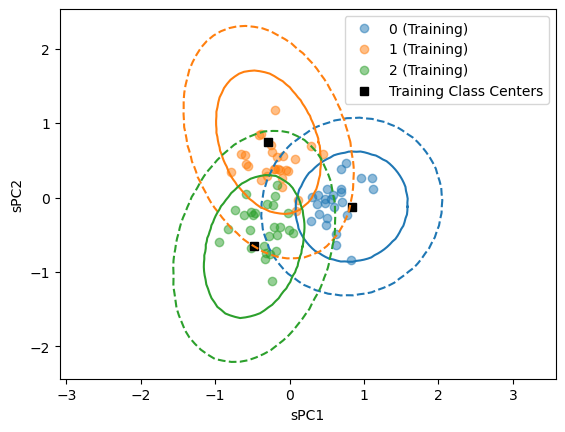


🗣 Sometimes the chemometrics community refers to these as "soft" models.

> However, this is very confusing 😖 since other communities (statistics, machine learning) use this term slightly differently.  [A soft classifier to these communities is just one which explicitly models the probability of belonging to each class](https://doi.org/10.1198%2Fjasa.2011.tm10319).  Classification subsequently occurs based on these probabilities.  You could either assign it to the most likely class ("hard" to a chemometrician) or assign it to all categories which reach a minimum threshold ("soft" to a chemometrician).  The latter is how a multilabel classifier performs.

> It appears this confusion originates with clustering algorithms.  "Hard clustering" refers to algorithms that assign a data point to exactly one cluster, while "soft clustering" (or "fuzzy clustering") assign finite probabilities that a point belongs to each (all) clusters. Clearly this is very similar to classification.  The idea originates with fuzzy C-means (FCM), also called fuzzy k-means: see the [original paper](https://www.tandfonline.com/doi/abs/10.1080/01969727308546046) and [subsequent improvments](https://books.google.com/books?hl=en&lr=&id=z6XqBwAAQBAJ&oi=fnd&pg=PR13&dq=bedzek+pattern+recognition+with+fuzzy+objective+function&ots=0jXPoSIgBu&sig=AI2VXMgRWnM19lWCN5bCiIQwjH4#v=onepage&q&f=false).

👉 This means it is no longer true that the row-wise sums of the confusion matrix add up to the total number of members of each class!  This creates some complications with the old metrics we use to evaluate classifiers so we need to change a few things.

If a model can assign a point to multiple categories, consider 2 extremes:

1. A model which assigns every point to every category.  This has high SNS since the model assigns each point to its correct category; however, it has a very low SPS because it also assigns it to every other category, too.  You can think of such a model as having an "infinitely large bubble" around all modeled class centers so all points are always included.  A confusion matrix would look like this (here there are 10 A's, 20 B's, and 30 C's):

| | Predicted A | Predicted B | Predicted C |
| --- | --- | --- | --- |
| Actual A | 10 | 10 | 10 |
| Actual B | 20 | 20 | 20 |
| Actual C | 30 | 30 | 30 |

2. A model which assigns no point to any category.  This has SPS = 1 since it completely avoids falsely assigning points to the wrong categories; however, it has a SNS = 0 because it also fails to assign any point to its correct category, too.  You can think of such a model as having an "infinitely small bubble" around all modeled class centers so no points are ever included.  A confusion matrix would look like this:

| | Predicted A | Predicted B | Predicted C |
| --- | --- | --- | --- |
| Actual A | 0 | 0 | 0 |
| Actual B | 0 | 0 | 0 |
| Actual C | 0 | 0 | 0 |

👉 Obviously, these two extremes are trivial. In reality we want to find a balance; essentially, we want the "bubble" around each modeled class center to be "big enough" to include many true members, but not so big it includes others.  This is easiest when the class centers in your model are small and separated by large distances.  The art 🎨 is building a model that has these features!

Ok, let's define our performance metrics for these classifiers. The definitions of sensitivity do not need to change relative to the multiclass case.

$$
TSNS = ACC = \frac{1}{M} \sum_{i=1}^N n_{i,i}
$$

$$
CSNS(k) = \frac{n_{k,k}}{M_k}
$$

However, we must change the way we compute specificities becase, unlike with multiclass (single label) classifiers, we now have:

$$
M \neq \sum_{i=1}^N \sum_{j=1}^N n_{i,j}
$$

Consider the following confusion matrix for a set of points with $M_0 = 25$, $M_1 = 28$, $M_2 = 27$:

| | Pred. 0 | Pred. 1 | Pred. 2 |
| --- | --- | --- | --- |
| Actual 0 | 25 | 1 | 0 |
| Actual 1 | 1 | 27 | 5 |
| Actual 2 | 0 | 6 | 27 |

In [ ]:
M = (25+28+27)
sum_cm = (25+1+1+27+5+6+27)
print(M, sum_cm)

80 92


In [ ]:
 TSNS = (25+27+27) / (25+28+27)
 CSNS = [
     25/25,
     27/28,
     27/27
 ]

 print(TSNS, CSNS)

0.9875 [1.0, 0.9642857142857143, 1.0]


However, consider our previous definition of

$$
TSPS_{\rm multiclass} = 1 - FPR = 1 - \frac{1}{M} \sum_{i \ne j} n_{i,j}
$$

For the example above, there doesn't seem to be any issue:

$$
TSPS_{\rm multiclass} = 1 - (1+1+5+6)/(25+28+27) = 0.8375
$$  

But what about the extreme example (1) we started out with?  In that case,

$$
TSPS_{\rm multiclass} = 1 - (10+20+30+10+20+30)/(10+20+30) = -1
$$  

Does a negative TSPS make any sense?  The answer is: not really...

---
> ❗ The reason this is negative is because each point can be a "false positive" for $N-1$ classes (it is a true positive for the remaining 1).  Recall how we reinterpreted a "positive" for multiclass classifiers.
---

To account for this, the formula can be adjusted by this factor.  Now the false positive *rate* is measured relative to the worst possible case (case 1 above; i.e., all boundaries are "infinitely large bubbles"):

$$
TSPS_{\rm multilabel} = 1 - FPR = 1 - \frac{1}{N-1} \frac{1}{M} \sum_{i \ne j} n_{i,j}
$$

However, most reasonable classifiers in reality are nowhere near as bad as that worst-case; as a result TSPS can seem larger than for other types of models if you use this metric especially when $N$ becomes large (order of 10).  TEFF is also affected since it is the geometric mean of TSPS and TSNS.  Be aware of this - TSPS for a multilabel model is not the same as TSPS for other types of models.


Note that class specificity does not have this issue.  Recall the formula is basically a column-wise sum excluding the row class $k$ corresponds to.  

$$
CSPS(k) = 1 - \frac{\sum_{i \ne k}n_{i,k}}{\sum_{i \ne k}M_i}
$$

As a result, the second term is always positive so we can retain this definition.  For our simple example here, these specificities are calculated as:

In [ ]:
 TSPS = 1 - (1+1+6+5) / (25+28+27) / (3 - 1)
 CSPS = [
     1 - (0+1)/(28+27),
     1 - (1+6)/(25+27),
     1 - (0+5)/(25+28)
 ]

 print(TSPS, CSPS)

0.91875 [0.9818181818181818, 0.8653846153846154, 0.9056603773584906]


# Rashomon sets

We have reviewed different metrics that can be used to evaluate chemometric models.  It is often naively assumed that the "best" model is the one with the "best" (e.g., usually the highest) metric.  For scientific applications, the model with the best metric is not always the most "useful" one.  In fact, recall the famous quote from statistician [George E. P. Box](https://en.wikipedia.org/wiki/George_E._P._Box): "All models are wrong, but some models are useful."  The goal here is to be as useful as possible, but "utility" is multifacted and can be hard to easily define.

When approaching a modeling problem, there is often a tradeoff between several factors such as:
* performance (metric)
* explainability
* data quantity

The 🎨 art of balancing these factors is one reason it is difficult to simply standardize modeling tasks across domains and applications.  Perhaps the best we can hope for is to standardize the tools used in this art (e.g., the color palette, so to speak).  This is one motivation behind the creation of [PyChemAuth](https://pychemauth.readthedocs.io/en/latest/index.html) in the first place.

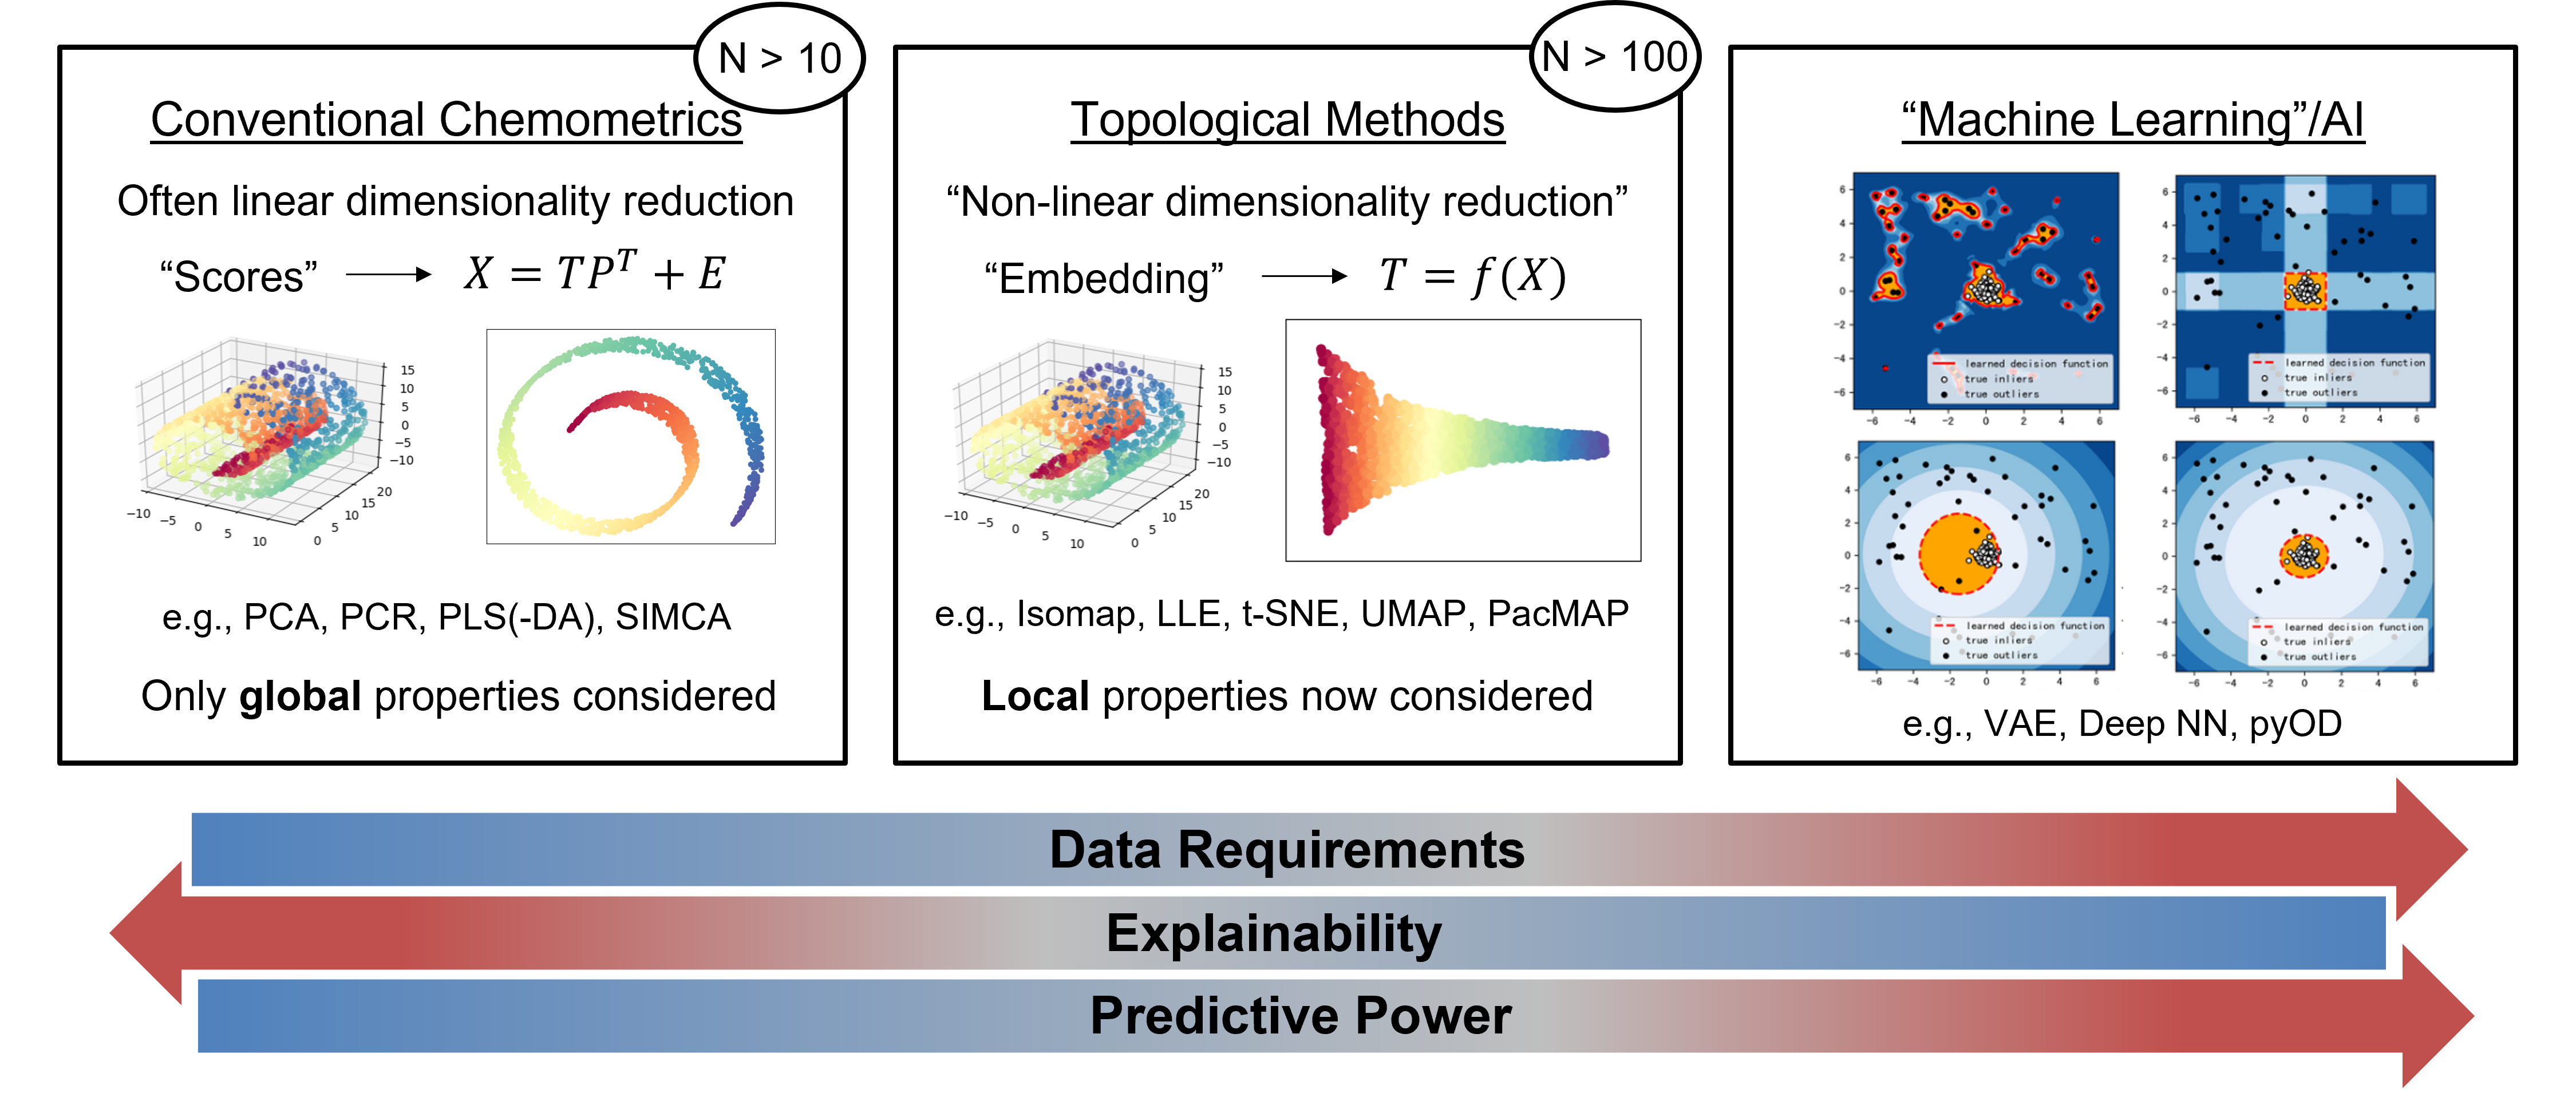

Although it is helpful to know if one model outperforms another, this is not the only reason for performing statistical comparisons.  After all, domain knowledge or other factors often enter into the decision to use one model or another in practice.  The ["no free lunch theorems"](https://en.wikipedia.org/wiki/No_free_lunch_theorem) suggest that there is no algorithm that will outperform all others on all problems.  [And in many cases](https://projecteuclid.org/journals/statistics-surveys/volume-16/issue-none/Interpretable-machine-learning-Fundamental-principles-and-10-grand-challenges/10.1214/21-SS133.full):

> "In many practical machine learning problems, there is a multiplicity of almost-equally-accurate models. This set of high performing models is called the [Rashomon](https://en.wikipedia.org/wiki/Rashomon) set, based on an observation of the Rashomon eﬀect by the statistician Leo Breiman. The Rashomon eﬀect occurs when there are multiple descriptions of the same event with possibly no ground truth."

The image below is from [Semenova et al., "On the Existence of Simpler Machine Learning Models," ACM International Conference Proceeding Series, 1827-1858 (2022)](https://dl.acm.org/doi/10.1145/3531146.3533232).

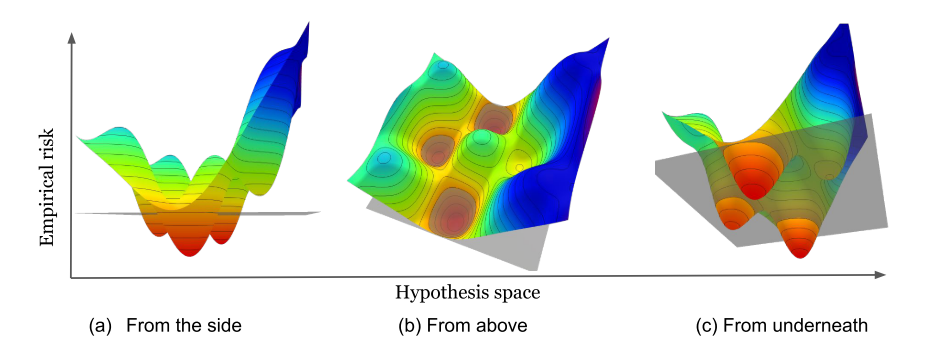

Simply put, there are often many solutions to a modeling problem; however, we would like to avoid ["Rube Goldberg Machines"](https://en.wikipedia.org/wiki/Rube_Goldberg_machine) as much as possible.

In the fields of environmental chemistry, biology, and other complex systems there are likely many correlated descriptors (columns in the feature matrix, X) that could be measured or used to build models.

> "In fact, the model that optimizes the training loss might not be the best to deploy in practice anyway due to the possibilities of poor generalization, trust issues, or encoded inductive biases that are undesirable."

👉 Models that are simpler and more transparent are often preferable in situations involving high risk to human or environmental health, compared to highly complex and inscrutable models even if they perform better. The tradeoff between complexity and transparency is not necessarily inevitable, but it is often important to interrogate how much we can simplify complex models, and what sort of loss in performance might this incur.

# Bias-Variance Tradeoff

The goal of supervised learning is to find a function that best approximates, or predicts, the data you have.  But we do not want to just "fit" the data we know about (or have collected), we also want this to "generalize" well.  That is, we want to be able to accurately predict the data at points we have not sampled and are not in the training set.

The [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) "describes the relationship between a model's complexity, the accuracy of its predictions, and how well it can make predictions on previously unseen data that were not used to train the model."

* Bias arises from incorrect assumptions in the model. For example, trying to fit a set of data points with a line, when it is actually following a quadratic curve. This is sometimes referred to as "underfitting."

* Conversely, variance is the error which comes the model being too sensitive to small fluctuations in the training data. For example, we can fit $n$ data points with an $n-1$ degree polynomial (2 points for a line, 3 for a quadratic, and so on).  This is sometimes referred to an "overfitting."



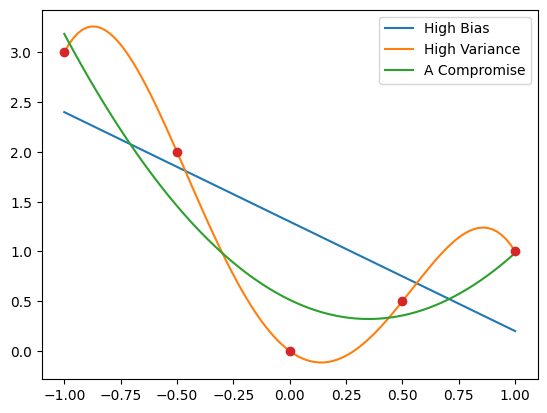

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array(
    [
        [0, 0],
        [1, 1],
        [-1, 3],
        [-0.5, 2],
        [0.5, 0.5]
    ]
)

high_bias = np.poly1d(np.polyfit(data[:,0], data[:,1], deg=1))
high_variance = np.poly1d(np.polyfit(data[:,0], data[:,1], deg=4))
compromise = np.poly1d(np.polyfit(data[:,0], data[:,1], deg=2))

x = np.linspace(-1, 1, 100)
plt.plot(x, [high_bias(x_) for x_ in x], label='High Bias')
plt.plot(x, [high_variance(x_) for x_ in x], label='High Variance')
plt.plot(x, [compromise(x_) for x_ in x], label='A Compromise')

plt.plot(data[:,0], data[:,1], 'o')
_ = plt.legend(loc='best')

Model "complexity" is often [falsely associated](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Motivation) with variance; i.e., a model with high complexity also has a high variance.  This is not technically true, but the association is understandable.  A model that has low [generalization error](https://en.wikipedia.org/wiki/Generalization_error) is one which performs well when tested on data that it was not trained on.  Models with the lowest error often reflect a balance between bias and variance.

👉 Typically, when we are searching for "simple" models in the Rashomon set, those with higher bias and lower variance tend to seem more interpretable, though this is not always the case.

[All models are wrong](https://allmodelsarewrong.github.io/biasvar.html) illustrates the bias-variance tradeoff very nicely.

It is important to define a few terms 🗣:
* Parameter - these are values in the model that are learned.  For example, the coefficients in the polynomial above.
* [Hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) - these are values in the pipeline that the learning process or architecture but are not optimized when we fit it to some data.  The polynomial degree is a hyperparameter in the example above.

Parameters are relatively simple to optimize using a loss (error) function for you model, like mean-squared error for OLS, but hyperparameters generally require [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to optimize.  This will be discussed in detail later, but it is important to understand that model hyperparameters are often what control "model complexity" and ultimately, the bias-variance tradeoff.